In [ ]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import datetime as dt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Spiderum/Data

/content/drive/MyDrive/Spiderum/Data


# Clean posts

In [ ]:
start = time.time()

posts = pd.read_csv('./posts.csv')
posts.head()

end = time.time()
print(end - start)

10.124074220657349


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17,19,26,28,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
posts.tail()

,_id,type,status,is_editor_pick,reading_time,tags,power_point,point,up_point,down_point,date_point,hot_point,controlversial_point,star,views_count,comment_count,is_edit,public_post,__v,body,cat_id,created_at,creator_id,slug,thumbnail,title,title_searchable,updated_at,new_id,description,content,new_title,url_description,og_image_url
49841,616d1906e268e3124eb7c57d,3,1,False,231.4,"[ { ""$oid"" : ""5a66423f053217118939d29b"" }, { ""...",0,1,1,0,1.634540e+12,3268.768252,5296.404568,False,2,0,0,False,0,NaN,19,2021-10-18T06:49:42.738Z,6167ed5a47f5fe441387cc7e,Oreo-mang-giai-dieu-Tet-trong-tung-mieng-banh-...,930518c02fdf11ec914d09dbd344244a.jpg,Oreo mang giai điệu Tết trong từng miếng bánh ...,NaN,2021-10-18T06:55:27.684Z,NaN,"Một chiến dịch Tết ""chơi trội"" của chiếc bánh ...",NaN,NaN,NaN,https://s3-ap-southeast-1.amazonaws.com/images...
49842,616d2690e268e3124eb7cac1,3,1,False,42.6,[ ],0,1,1,0,1.634543e+12,3268.821739,5296.491217,False,4,0,1,False,0,NaN,19,2021-10-18T07:47:28.664Z,616d22c947f5fe441387d27c,About-Thuecanho123-UC4ZkOEH617o,b2c1a9f02fe711ec914d09dbd344244a.png,About Thuecanho123,NaN,2021-10-18T07:47:58.791Z,NaN,Bạn có thể dễ dàng lựa chọn nhiều loại căn hộ ...,NaN,About Thuecanho123,NaN,https://s3-ap-southeast-1.amazonaws.com/images...
49843,616d28c4e268e3124eb7cc87,3,1,False,75.6,[ ],0,1,1,0,1.634544e+12,3268.830439,5296.505312,False,8,0,1,False,0,NaN,19,2021-10-18T07:56:52.466Z,616d22c947f5fe441387d27c,Can-ho-chung-cu-Quan-Binh-Tan-moi-nhat-JAGjhjQ...,2ea9ad002fe911ec914d09dbd344244a.jpg,Căn hộ chung cư Quận Bình Tân mới nhất,NaN,2021-10-18T08:10:22.857Z,NaN,Căn hộ chung cư Quận Bình Tân Cho thuê giá rẻ ...,NaN,Căn hộ chung cư Quận Bình Tân mới nhất,NaN,https://s3-ap-southeast-1.amazonaws.com/images...
49844,616d2b26e268e3124eb7d149,3,1,False,354.4,[ ],0,1,1,0,1.634544e+12,3268.839855,5296.520566,False,1,0,0,False,0,NaN,14,2021-10-18T08:07:02.635Z,60ebe69e3583b555c24de2f7,Trai-long-ve-su-co-don-ywx3uBx8QNVy,defaultthumbnail.png,Trải lòng về sự cô đơn,NaN,2021-10-18T08:07:03.628Z,NaN,Ngồi viết cho đỡ buồn,NaN,NaN,NaN,NaN
49845,616d2d7ae268e3124eb7d704,3,1,False,114.2,[ ],0,1,1,0,1.634545e+12,3268.849045,5296.535453,False,1,0,0,False,0,NaN,14,2021-10-18T08:16:58.137Z,610e9d422b274ba68b87efb3,Ngay-18102021-2q4Z25t6ZbwS,defaultthumbnail.png,Ngày 18/10/2021,NaN,2021-10-18T08:16:59.313Z,NaN,Hôm nay quả là một ngày buồn tôi chưa bao giờ ...,NaN,NaN,NaN,NaN


In [ ]:
# Drop status 0
posts = posts[posts['status'] == 1]

# Drop upvote < 0
posts = posts[posts['point'] >= 1]

# Drop na values
posts.dropna(subset=['body'], inplace=True)

# Drop duplicates (keep the one has most views)
posts.sort_values(by=['views_count'], ascending=False, inplace=True)
posts.drop_duplicates(subset=['body'], inplace=True)
posts.sort_index(inplace=True)

# Add url to slug
posts['redirect_url'] = 'https://spiderum.com/bai-dang/' + posts['slug']

# Remain important columns
posts = posts[['redirect_url', 'body', 'views_count']]

In [ ]:
posts.head()

,redirect_url,body,views_count
1,https://spiderum.com/bai-dang/Chuyen-tinh-dam-...,"<div>Một lần can ngăn bạn bè xô xát, anh vô ý ...",6817
2,https://spiderum.com/bai-dang/Tinh-nguoi-3,<div>Ông là tổng giám đốc một tập đoàn lớn nhấ...,10464
3,https://spiderum.com/bai-dang/Danh-cho-nhung-b...,http://cafebiz.vn/xu-huong-cong-nghe/khi-gia-n...,9811
4,https://spiderum.com/bai-dang/Nghe-thuat-dam-p...,http://ybox.vn/nghe-nghiep/10-loi-khuyen-khi-d...,7534
5,https://spiderum.com/bai-dang/15-DINH-LUAT-VE-...,https://www.ohay.tv/view/15-dinh-luat-ve-cuoc-...,4914


In [ ]:
posts.to_csv('./posts_cleaned.csv', index=False)

## Clean useractionhistories

In [ ]:
start = time.time()
data = pd.read_csv('./useractionhistories.csv')
end = time.time()
print(end - start)

73.86236906051636


In [ ]:
data.tail()

,_id,user_id,object_id,object,action,redirect_url,created_at,status,__v
16944643,60e9a8068f151f5b0add95ef,86130,42269,post,view,https://spiderum.com/bai-dang/Giang-sinh-phai-...,2021-07-10T14:00:38.323Z,1,0
16944644,60e9a80af615e061ab467354,40234,23300,post,view,https://spiderum.com/bai-dang/DAY-LA-CACH-DE-H...,2021-07-10T14:00:42.031Z,1,0
16944645,60e9a80accc8d250dd723b2a,85737,48573,post,view,https://spiderum.com/bai-dang/Truyen-dai-Mua-y...,2021-07-10T14:00:42.670Z,1,0
16944646,60e9a80f8010d664fb709d68,82254,9551,post,view,https://spiderum.com/bai-dang/Stoicism-P5-Sene...,2021-07-10T14:00:47.447Z,1,0
16944647,60e9a8108f151f5b0add95f0,79350,48581,post,view,https://spiderum.com/bai-dang/Whats-on-Netflix...,2021-07-10T14:00:48.583Z,1,0


In [ ]:
# Remove not-register user
data = data[data['user_id'] != -1]

# Drop unnecessary columns
data.drop(columns=['_id', '__v', 'status', 'object_id'], inplace=True)

print('The number of rows: ' + str(len(data)))

In [ ]:
# Convert into datetime
def convert(x):
    year = int(x[:4])
    month = int(x[5:7])
    day = int(x[8:10])
    hour = int(x[11:13])
    minute = int(x[14:16])
    second = int(x[17:])
    return dt.datetime(year, month, day, hour, minute, second)

data['created_at'] = data['created_at'].str[:19].apply(lambda x: convert(x))

In [ ]:
# Rename some actions
data.replace({'action': {'trả lời': 'reply', 'bình luận': 'comment', 'lưu': 'save', 'bỏ vote': 'unvote'},
              'object': {'bình luận': 'comment'}}, inplace=True)

# Just take the object "post" and "comment"
data = data[(data['object'] == 'post') | (data['object'] == 'comment')]

In [ ]:
# Convert url link comment to link post
def convert(x):
    if '?comment' not in x:
        return x
    else:
        return x[:x.index('?comment')]

data['redirect_url'] = data['redirect_url'].apply(lambda x: convert(x))

In [ ]:
# Just keep urls stay in posts dataframe
data = data[data['redirect_url'].isin(posts['redirect_url'])]

In [ ]:
data.head()

,user_id,object,action,redirect_url,created_at
0,2446,post,upvote,https://spiderum.com/bai-dang/Mot-bai-viet-cu-...,2017-03-27 19:56:44
1,8,post,upvote,https://spiderum.com/bai-dang/Triet-li-tu-ba-d...,2017-03-27 20:13:13
2,8,post,upvote,https://spiderum.com/bai-dang/Ve-triet-hoc-Tri...,2017-03-27 20:13:18
3,2408,post,sửa,https://spiderum.com/bai-dang/Mot-bai-viet-cu-...,2017-03-27 20:16:31
4,2408,post,sửa,https://spiderum.com/bai-dang/Triet-li-tu-ba-d...,2017-03-27 20:16:53


In [ ]:
# Save to a new csv file
data.to_csv('./useraction_cleaned.csv', index=False)

**Preprocess vote information**

In [ ]:
# Read file csv
useraction_CF = pd.read_csv('./useraction_cleaned.csv')

In [ ]:
# Preprocess vote information
vote_CF = useraction_CF[(useraction_CF['action'] == 'upvote') | (useraction_CF['action'] == 'downvote') | (useraction_CF['action'] == 'unvote')][useraction_CF['object'] == 'post']
vote_CF.tail(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,user_id,object,action,redirect_url,created_at
3610073,10701,post,upvote,https://spiderum.com/bai-dang/Vi-buon-kd8,2019-12-31 22:33:53
3610076,10701,post,upvote,https://spiderum.com/bai-dang/Bon-nghe-sy-gme,2019-12-31 22:35:09
3610077,10701,post,upvote,https://spiderum.com/bai-dang/Luong-tam-dao-du...,2019-12-31 22:35:17
3610100,36392,post,upvote,https://spiderum.com/bai-dang/Viet-cho-em-101-...,2019-12-31 23:53:42
3610102,36392,post,upvote,https://spiderum.com/bai-dang/Dem-cuoi-nam-kj0,2019-12-31 23:55:29


In [ ]:
# Contraction of df
vote_CF = vote_CF.groupby(['user_id', 'redirect_url']).nth(-1).reset_index()
vote_CF = vote_CF[vote_CF['action'] != 'unvote']
vote_CF = vote_CF[['user_id', 'redirect_url', 'action', 'created_at']]
vote_CF.head()

,user_id,redirect_url,action,created_at
0,5,https://spiderum.com/bai-dang/Toi-chi-muon-con...,upvote,2019-08-09 07:00:21
1,8,https://spiderum.com/bai-dang/-c1l,upvote,2018-09-16 06:17:09
2,8,https://spiderum.com/bai-dang/01-Chao-dang-ay-...,upvote,2019-10-09 22:38:35
3,8,https://spiderum.com/bai-dang/03-lan-lam-xe-om...,upvote,2017-05-26 08:44:31
4,8,https://spiderum.com/bai-dang/06102019-REVIEW-...,upvote,2019-11-23 20:22:48


**Preprocess comment information**

In [ ]:
comment_CF = useraction_CF[(useraction_CF['action'] == 'comment') | (useraction_CF['object'] == 'comment')]
comment_CF.head()

,user_id,object,action,redirect_url,created_at
14,5552,comment,reply,https://spiderum.com/bai-dang/Thiet-ke-luat-ch...,2017-03-27 20:27:29
15,5552,comment,upvote,https://spiderum.com/bai-dang/Thiet-ke-luat-ch...,2017-03-27 20:27:30
16,5552,comment,reply,https://spiderum.com/bai-dang/Thiet-ke-luat-ch...,2017-03-27 20:27:40
25,4025,comment,upvote,https://spiderum.com/bai-dang/Mot-bai-viet-cu-...,2017-03-27 20:33:04
27,4025,comment,upvote,https://spiderum.com/bai-dang/Mot-bai-viet-cu-...,2017-03-27 20:33:23


In [ ]:
# Process comment_CF

comment_CF['action'] = 'comment'
comment_CF = comment_CF[['user_id', 'redirect_url', 'action', 'created_at']]
comment_CF.drop_duplicates(subset=['user_id', 'redirect_url'], keep='last', inplace=True)
comment_CF.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,redirect_url,action,created_at
27,4025,https://spiderum.com/bai-dang/Mot-bai-viet-cu-...,comment,2017-03-27 20:33:23
41,8,https://spiderum.com/bai-dang/Ve-triet-hoc-Tri...,comment,2017-03-27 20:45:56
42,8,https://spiderum.com/bai-dang/Triet-li-tu-ba-d...,comment,2017-03-27 21:00:09
43,8,https://spiderum.com/bai-dang/Cac-ki-thuat-tuy...,comment,2017-03-27 21:16:10
46,5552,https://spiderum.com/bai-dang/Learning-How-to-...,comment,2017-03-27 22:14:22


**Preprocess save information**

In [ ]:
save_CF = useraction_CF[(useraction_CF['action'] == 'save') & (useraction_CF['object'] == 'post')]
save_CF.head()

,user_id,object,action,redirect_url,created_at
11,4025,post,save,https://spiderum.com/bai-dang/Vi-sao-Deadpool-...,2017-03-27 20:22:08
247,6739,post,save,https://spiderum.com/bai-dang/Nhat-ky-ngay-and...,2017-03-28 08:36:10
248,6739,post,save,https://spiderum.com/bai-dang/Nhat-ky-ngay-and...,2017-03-28 08:36:14
411,3904,post,save,https://spiderum.com/bai-dang/Cuoc-chien-tranh...,2017-03-28 20:46:07
424,4025,post,save,https://spiderum.com/bai-dang/Kitchen-101-Cau-...,2017-03-29 01:00:19


In [ ]:
save_CF = save_CF[['user_id', 'redirect_url', 'action', 'created_at']]
save_CF.drop_duplicates(subset=['user_id', 'redirect_url'], keep='last', inplace=True)
save_CF.head()

,user_id,redirect_url,action,created_at
11,4025,https://spiderum.com/bai-dang/Vi-sao-Deadpool-...,save,2017-03-27 20:22:08
248,6739,https://spiderum.com/bai-dang/Nhat-ky-ngay-and...,save,2017-03-28 08:36:14
411,3904,https://spiderum.com/bai-dang/Cuoc-chien-tranh...,save,2017-03-28 20:46:07
424,4025,https://spiderum.com/bai-dang/Kitchen-101-Cau-...,save,2017-03-29 01:00:19
427,6871,https://spiderum.com/bai-dang/Dua-con-cua-than...,save,2017-03-29 01:06:44


**Final df**

In [ ]:
final_df = vote_CF.append(comment_CF).append(save_CF)
final_df = final_df.groupby(['user_id', 'redirect_url']).agg({'action': lambda x: tuple(x), 'created_at': lambda x: max(list(x))}).reset_index()
final_df.head()

,user_id,redirect_url,action,created_at
0,5,https://spiderum.com/bai-dang/Toi-chi-muon-con...,"(upvote,)",2019-08-09 07:00:21
1,8,https://spiderum.com/bai-dang/-c1l,"(upvote,)",2018-09-16 06:17:09
2,8,https://spiderum.com/bai-dang/01-Chao-dang-ay-...,"(upvote,)",2019-10-09 22:38:35
3,8,https://spiderum.com/bai-dang/03-lan-lam-xe-om...,"(upvote,)",2017-05-26 08:44:31
4,8,https://spiderum.com/bai-dang/06102019-REVIEW-...,"(upvote,)",2019-11-23 20:22:48


In [ ]:
def action_to_rating(x):
    if 'downvote' in x:
        return -1
    return len(x)

final_df['rating'] = final_df['action'].apply(lambda x: action_to_rating(x))
final_df.head()

,user_id,redirect_url,action,created_at,rating
0,5,https://spiderum.com/bai-dang/Toi-chi-muon-con...,"(upvote,)",2019-08-09 07:00:21,1
1,8,https://spiderum.com/bai-dang/-c1l,"(upvote,)",2018-09-16 06:17:09,1
2,8,https://spiderum.com/bai-dang/01-Chao-dang-ay-...,"(upvote,)",2019-10-09 22:38:35,1
3,8,https://spiderum.com/bai-dang/03-lan-lam-xe-om...,"(upvote,)",2017-05-26 08:44:31,1
4,8,https://spiderum.com/bai-dang/06102019-REVIEW-...,"(upvote,)",2019-11-23 20:22:48,1


In [ ]:
final_df[['user_id', 'redirect_url', 'rating', 'created_at']].to_csv('./Data for CF/cleaned_data.csv', index=False)

# **Preprocess interact information**

In [ ]:
interact_CF = useraction_CF[useraction_CF['action'] == 'view'][['user_id', 'redirect_url', 'created_at']] \
              .append(final_df[['user_id', 'redirect_url', 'created_at']]) \
              .sort_values(by=['user_id', 'created_at']) \
              .drop_duplicates(subset=['user_id', 'redirect_url'], keep='last')
len(interact_CF)

1774969

In [ ]:
interact_CF.head()

,user_id,redirect_url,created_at
0,5,https://spiderum.com/bai-dang/Toi-chi-muon-con...,2019-08-09 07:00:21
3399,8,https://spiderum.com/bai-dang/Ve-triet-hoc-Tri...,2017-03-27 20:45:56
509,8,https://spiderum.com/bai-dang/Cac-ki-thuat-tuy...,2017-03-27 21:16:10
2927,8,https://spiderum.com/bai-dang/Tha-khong-co-dao...,2017-03-28 03:11:40
2869,8,https://spiderum.com/bai-dang/Tai-sao-the-gioi...,2017-03-28 03:11:46


In [ ]:
interact_CF.to_csv('./Data for CF/interact_CF.csv', index=False)

**Analysis session**

In [ ]:
useraction_view = useraction_CF[useraction_CF['action'] == 'view']
useraction_view.sort_values(by=['user_id', 'created_at'], inplace=True)
useraction_view['created_at_shift'] = useraction_view.groupby('user_id')['created_at'].shift()
useraction_view['diff_time'] = useraction_view['created_at'] - useraction_view['created_at_shift']
useraction_view.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

,user_id,object_id,object,action,redirect_url,created_at,created_at_shift,diff_time
10204,8,5800,post,view,https://spiderum.com/bai-dang/Dua-con-cua-than...,2017-04-21 10:42:24,NaT,NaT
10225,8,7371,post,view,https://spiderum.com/bai-dang/Cau-dinh-thi-tru...,2017-04-21 10:52:46,2017-04-21 10:42:24,0 days 00:10:22
10227,8,7527,post,view,https://spiderum.com/bai-dang/10-tran-chien-la...,2017-04-21 10:53:52,2017-04-21 10:52:46,0 days 00:01:06
10251,8,7371,post,view,https://spiderum.com/bai-dang/Cau-dinh-thi-tru...,2017-04-21 10:58:53,2017-04-21 10:53:52,0 days 00:05:01
10262,8,7306,post,view,https://spiderum.com/bai-dang/Nhung-cu-lua-lic...,2017-04-21 11:04:14,2017-04-21 10:58:53,0 days 00:05:21


In [ ]:
list_diff_time = list(useraction_view['diff_time'])
list_sessions = [1]
for i in range(1, len(list_diff_time)):
    if pd.isna(list_diff_time[i]) or list_diff_time[i] > dt.timedelta(minutes=30):
        list_sessions.append(list_sessions[-1] + 1)
    else:
        list_sessions.append(list_sessions[-1])
useraction_view['session'] = list_sessions
useraction_view.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,object_id,object,action,redirect_url,created_at,created_at_shift,diff_time,session
10204,8,5800,post,view,https://spiderum.com/bai-dang/Dua-con-cua-than...,2017-04-21 10:42:24,NaT,NaT,1
10225,8,7371,post,view,https://spiderum.com/bai-dang/Cau-dinh-thi-tru...,2017-04-21 10:52:46,2017-04-21 10:42:24,0 days 00:10:22,1
10227,8,7527,post,view,https://spiderum.com/bai-dang/10-tran-chien-la...,2017-04-21 10:53:52,2017-04-21 10:52:46,0 days 00:01:06,1
10251,8,7371,post,view,https://spiderum.com/bai-dang/Cau-dinh-thi-tru...,2017-04-21 10:58:53,2017-04-21 10:53:52,0 days 00:05:01,1
10262,8,7306,post,view,https://spiderum.com/bai-dang/Nhung-cu-lua-lic...,2017-04-21 11:04:14,2017-04-21 10:58:53,0 days 00:05:21,1


In [ ]:
pd.DataFrame(data={'Cách làm đúng': useraction_view.groupby('session')['redirect_url'].count().value_counts(),
                   'Cách làm sai': useraction_view.groupby('session')['redirect_url'].nunique().value_counts()}).head(10)

,Cách làm đúng,Cách làm sai
1,620098.0,692736.0
2,267459.0,276084.0
3,151067.0,141949.0
4,92419.0,81113.0
5,59785.0,49415.0
6,40548.0,31972.0
7,27990.0,21062.0
8,20368.0,14537.0
9,14929.0,10485.0
10,11253.0,7503.0


In [ ]:
session_stat = useraction_view.groupby('session')['redirect_url'].count().value_counts()
session_stat

1      620098
2      267459
3      151067
4       92419
5       59785
        ...  
211         1
209         1
208         1
203         1
991         1
Name: redirect_url, Length: 261, dtype: int64

Text(0.5, 1.0, "Histogram of sessions' number of posts")

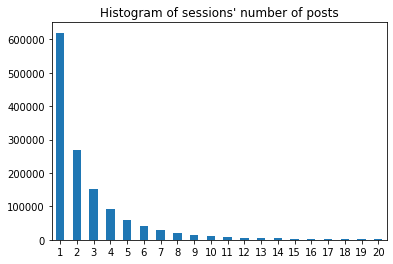

In [ ]:
import matplotlib.pyplot as plt

session_stat[:20].plot.bar()
plt.xticks(rotation=0)
plt.title("Histogram of sessions' number of posts")

In [ ]:
session_stat.sum()

1353579